In [9]:
import urllib
from enum import Enum

import cv2
import numpy as np
from matplotlib import pyplot as plt

(768, 1024)


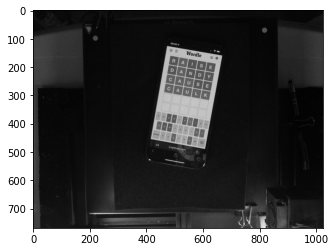

In [10]:
img = cv2.imread("images/foo.jpg")
# read the image from a url
# url = "http://wordle.local:8000/grab_frame"
# response = urllib.request.urlopen(url)
# data = response.read()
# turn into an open cv image
# img = cv2.imdecode(np.frombuffer(data, np.uint8), cv2.IMREAD_COLOR)

scale = 1024 / img.shape[1]
resized = cv2.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale)))
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
print(gray.shape)
plt.imshow(gray, cmap="gray")

rectangle l=195.80091930325557, r=193.19679086361657, t=334.6072324382723, b=332.10389940499044
top_right [609 489]
bottom_left [473 125]
top_left [415 455]
bottom_right [667 159]


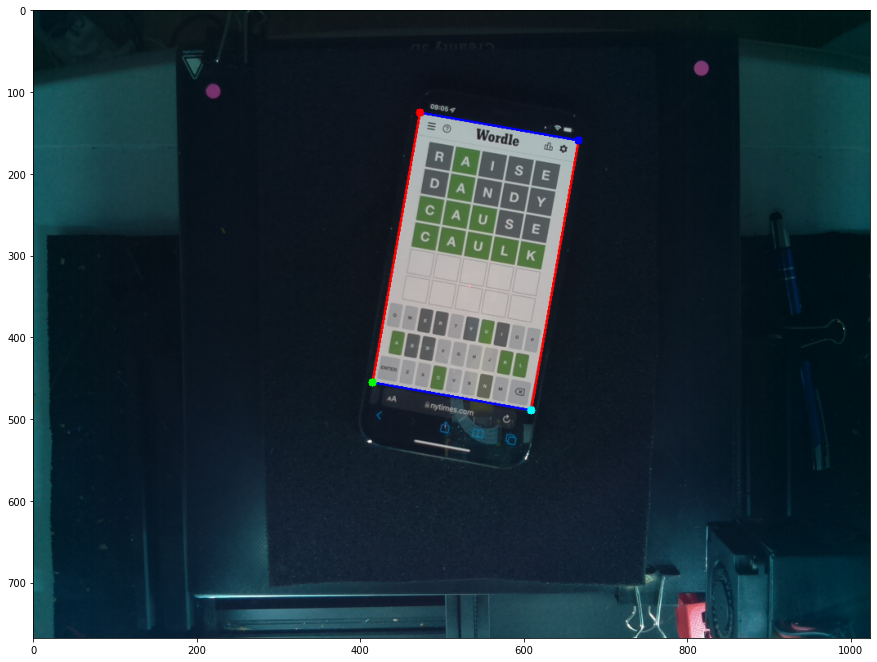

In [11]:
def find_corners(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresholed = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]
    contours, _ = cv2.findContours(
        thresholed.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )

    for c in contours:
        # compute the center of the contour, then detect the name of the
        # shape using only the contour
        M = cv2.moments(c)
        if M["m00"] != 0:
            # get the approximate polygon of the contour
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.04 * peri, True)
            # if we've got four points then it's a rectangle
            if len(approx) == 4:
                # are the lengths of each side of the rectangle the same?
                length_b = cv2.norm(approx[0], approx[1])
                length_t = cv2.norm(approx[2], approx[3])
                length_l = cv2.norm(approx[0], approx[3])
                length_r = cv2.norm(approx[1], approx[2])
                if (
                    length_l > 0.9 * length_r
                    and length_l < 1.1 * length_r
                    and length_t > 0.9 * length_b
                    and length_t < 1.1 * length_b
                    and length_l > 0.1 * image.shape[1]
                    and length_r > 0.1 * image.shape[1]
                    and length_t > 0.1 * image.shape[0]
                    and length_b > 0.1 * image.shape[0]
                ):
                    print(
                        f"rectangle l={length_l}, r={length_r}, t={length_t}, b={length_b}"
                    )
                    # draw the contour and label the shape
                    # cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
                    rect = cv2.minAreaRect(
                        c
                    )  # get a rectangle rotated to have minimal area
                    box = cv2.boxPoints(rect)  # get the box from the rectangle
                    box = np.int0(box)
                    cv2.line(image, tuple(box[0]), tuple(box[1]), (255, 0, 0), 2)
                    cv2.line(image, tuple(box[1]), tuple(box[2]), (0, 0, 255), 2)
                    cv2.line(image, tuple(box[2]), tuple(box[3]), (255, 0, 0), 2)
                    cv2.line(image, tuple(box[3]), tuple(box[0]), (0, 0, 255), 2)

                    # work out the bottom left corner of the rectangle - just use the manhattan distance from the 0,0
                    bottom_left = box[0]
                    bottom_left_distance = 1e9
                    top_right = box[0]
                    top_right_distance = 0
                    top_left = box[0]
                    top_left_distance = 1e9
                    bottom_right = box[0]
                    bottom_right_distance = 1e9
                    for point in box:
                        # top right and bottom left we can just use the manhattan distance from 0,0
                        distance = abs(point[0]) + abs(point[1])
                        if distance < bottom_left_distance:
                            bottom_left_distance = distance
                            bottom_left = point
                        if distance > top_right_distance:
                            top_right_distance = distance
                            top_right = point
                        # top left is the manhattan distance from 0, height
                        distance = abs(point[0]) + abs(image.shape[0] - point[1])
                        if distance < top_left_distance:
                            top_left_distance = distance
                            top_left = point
                        # bottom right is the manhattan distance from width, 0
                        distance = abs(image.shape[1] - point[0]) + abs(point[1])
                        if distance < bottom_right_distance:
                            bottom_right_distance = distance
                            bottom_right = point

                    print("top_right", top_right)
                    print("bottom_left", bottom_left)
                    print("top_left", top_left)
                    print("bottom_right", bottom_right)

                    return top_right, bottom_left, top_left, bottom_right
    return None, None, None, None


result = resized.copy()
top_right, bottom_left, top_left, bottom_right = find_corners(result)

# get the affine transform that maps from the rectangle we've found to the iphone screen
SCREEN_WIDTH = 1170
SCREEN_HEIGHT = 2532 - (404 + 140)

image_points = np.float32([bottom_left, bottom_right, top_right])
screen_points = np.float32([(0, 0), (SCREEN_WIDTH, 0), (SCREEN_WIDTH, SCREEN_HEIGHT)])
phone_transform = cv2.getAffineTransform(screen_points, image_points)

# draw circles where we think the corners of the phone are
bl_x, bl_y = cv2.transform(np.array([[[0, 0]]]), phone_transform).squeeze()
br_x, br_y = cv2.transform(np.array([[[SCREEN_WIDTH, 0]]]), phone_transform).squeeze()
tl_x, tl_y = cv2.transform(np.array([[[0, SCREEN_HEIGHT]]]), phone_transform).squeeze()
tr_x, tr_y = cv2.transform(
    np.array([[[SCREEN_WIDTH, SCREEN_HEIGHT]]]), phone_transform
).squeeze()

bl_x = int(bl_x)
bl_y = int(bl_y)
br_x = int(br_x)
br_y = int(br_y)
tl_x = int(tl_x)
tl_y = int(tl_y)
cv2.circle(result, (bl_x, bl_y), 5, (0, 0, 255), -1)
cv2.circle(result, (br_x, br_y), 5, (255, 0, 0), -1)
cv2.circle(result, (tl_x, tl_y), 5, (0, 255, 0), -1)
cv2.circle(result, (tr_x, tr_y), 5, (255, 255, 0), -1)


plt.figure(figsize=(15, 15))
rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(rgb, aspect="equal")

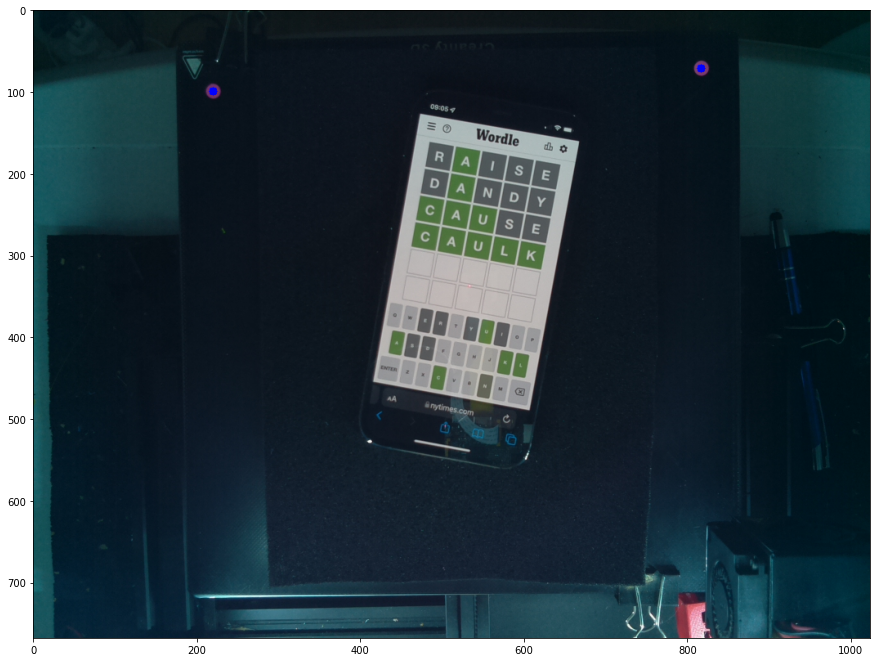

In [16]:
# locate the purple circle in the image - this is our 0,0 point

hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)

lower_purple = np.array([150, 100, 100])
upper_purple = np.array([180, 255, 255])
mask = cv2.inRange(hsv, lower_purple, upper_purple)
mask = cv2.erode(mask, None, iterations=2)
result = resized.copy()
contours, hierarchy = cv2.findContours(
    mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
)
for c in contours:
    M = cv2.moments(c)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        if cY < resized.shape[0] * 0.3:
            cv2.circle(result, (cX, cY), 5, (255, 0, 0), -1)

# locate the 0,0 circle - it's the one in the top right

plt.figure(figsize=(15, 15))
rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(rgb, cmap="gray", aspect="equal")

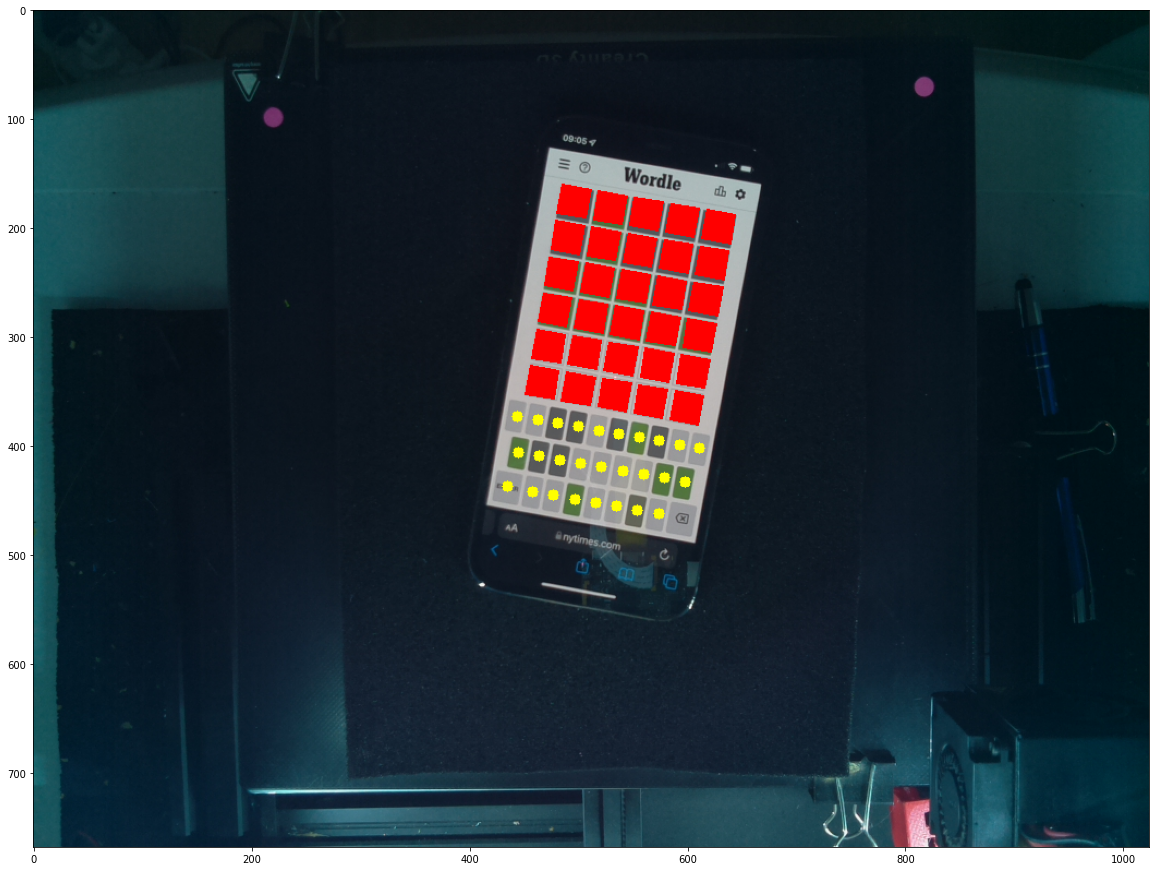

In [15]:
def get_grid_polygon(row, col, transform):
    # some magic constants from roughly measuring a screenshot
    GRID_START_X = 107
    GRID_START_Y = 193
    GRID_SIZE_X = 160
    GRID_SPACING_X = 40
    GRID_SIZE_Y = 160
    GRID_SPACING_Y = 40

    g1_x = GRID_START_X + col * (GRID_SIZE_X + GRID_SPACING_X)
    g1_y = GRID_START_Y + row * (GRID_SIZE_Y + GRID_SPACING_Y)
    bl1_x, bl1_y = cv2.transform(
        np.array([[[int(g1_x), int(g1_y)]]]), transform
    ).squeeze()
    bl2_x, bl2_y = cv2.transform(
        np.array([[[int(g1_x + GRID_SIZE_X), int(g1_y)]]]), transform
    ).squeeze()
    bl3_x, bl3_y = cv2.transform(
        np.array([[[int(g1_x + GRID_SIZE_X), int(g1_y + GRID_SIZE_Y)]]]),
        transform,
    ).squeeze()
    bl4_x, bl4_y = cv2.transform(
        np.array([[[int(g1_x), int(g1_y + GRID_SIZE_Y)]]]), transform
    ).squeeze()
    return np.array(
        [
            (int(bl1_x), int(bl1_y)),
            (int(bl2_x), int(bl2_y)),
            (int(bl3_x), int(bl3_y)),
            (int(bl4_x), int(bl4_y)),
        ]
    )


def get_key_coords(key, transform):
    KEY_ROWS = [
        ["q", "w", "e", "r", "t", "y", "u", "i", "o", "p"],
        ["a", "s", "d", "f", "g", "h", "j", "k", "l"],
        ["z", "x", "c", "v", "b", "n", "m"],
    ]
    # some magic constants from roughly measuring a screenshot
    KEYBOARD_KEY_SPACE_X = 17
    KEYBOARD_KEY_HEIGHT = 174

    KEY_ROW_X = [40, 73, 190]
    KEY_ROW_Y = [1390, 1583, 1780]
    KEY_WIDTH = [95, 99, 99]

    KEYBOARD_ENTER_KEY_X = 23
    KEYBOARD_ENTER_KEY_Y = 1780
    KEYBOARD_ENTER_KEY_WIDTH = 147
    KEYBOARD_ENTER_KEY_HEIGHT = 170

    # special handling for the enter key
    if key == "\n":
        key_x = KEYBOARD_ENTER_KEY_X + KEYBOARD_ENTER_KEY_WIDTH / 2
        key_y = KEYBOARD_ENTER_KEY_Y + KEYBOARD_ENTER_KEY_HEIGHT / 2
        return cv2.transform(
            np.array([[[int(key_x), int(key_y)]]]), transform
        ).squeeze()

    # find the key in the keyboard
    for row_idx, row in enumerate(KEY_ROWS):
        if key in row:
            key_idx = row.index(key)
            key_x = (
                KEY_ROW_X[row_idx]
                + key_idx * (KEY_WIDTH[row_idx] + KEYBOARD_KEY_SPACE_X)
                + KEY_WIDTH[row_idx] / 2
            )
            key_y = KEY_ROW_Y[row_idx] + KEYBOARD_KEY_HEIGHT / 2
            return cv2.transform(
                np.array([[[int(key_x), int(key_y)]]]), transform
            ).squeeze()


marked_up = resized.copy()
for col in range(0, 5):
    for row in range(0, 6):
        poly = get_grid_polygon(row, col, phone_transform)
        cv2.fillPoly(marked_up, [poly], (0, 0, 255))

for key in "abcdefghijklmnopqrstuvwxyz\n":
    key_x, key_y = get_key_coords(key, phone_transform)
    cv2.circle(marked_up, (key_x, key_y), 5, (0, 255, 255), -1)

plt.figure(figsize=(20, 20))
rgb = rgb = cv2.cvtColor(marked_up, cv2.COLOR_BGR2RGB)
plt.imshow(rgb, cmap="gray", aspect="equal")

In [18]:
# get the dominant color within a polygon
class PolygonColor(Enum):
    NONE = 0
    GREEN = 1
    ORANGE = 2


def get_dominant_color(green_image, orange_image, polygon, threshold):
    mask = np.zeros(green_image.shape, dtype="uint8")
    cv2.fillPoly(mask, [polygon], 255)
    masked_green_img = cv2.bitwise_and(green_image, mask)
    masked_orange_img = cv2.bitwise_and(orange_image, mask)
    # cound how many pixels are in the masked images
    green_pixels = cv2.countNonZero(masked_green_img)
    orange_pixels = cv2.countNonZero(masked_orange_img)
    if green_pixels > threshold:
        return PolygonColor.GREEN
    elif orange_pixels > threshold:
        return PolygonColor.ORANGE
    else:
        return PolygonColor.NONE


lower_orange = np.array([0, 100, 100])
upper_orange = np.array([30, 255, 255])

lower_green = np.array([35, 50, 100])
upper_green = np.array([75, 255, 255])

green_image = cv2.inRange(hsv, lower_green, upper_green)
orange_image = cv2.inRange(hsv, lower_orange, upper_orange)

for row in range(0, 6):
    for col in range(0, 5):
        poly = get_grid_polygon(row, col, phone_transform)
        color = get_dominant_color(green_image, orange_image, poly, 100)
        if color != PolygonColor.NONE:
            print(f"{color} at {row}, {col}")

plt.imshow(green_image, cmap="gray", aspect="equal")

PolygonColor.GREEN at 0, 1
PolygonColor.GREEN at 1, 1
PolygonColor.GREEN at 2, 0
PolygonColor.GREEN at 2, 1
PolygonColor.GREEN at 2, 2
PolygonColor.GREEN at 3, 0
PolygonColor.GREEN at 3, 1
PolygonColor.GREEN at 3, 2
PolygonColor.GREEN at 3, 3
PolygonColor.GREEN at 3, 4
